In [1]:
#Basic Imports 
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Natural Language Processing 
import nltk
import re 
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#Sklearn
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

#Classifiers and Models
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#Model Evaluation and Interpretation
import shap
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

#Ignore Any Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Let's read in our data 
df = pd.read_csv('dataframe.csv')
#Reset the index
df = df.set_index("Unnamed: 0")
#And create a binary target 
df['Label'] = df['Label'].map({'Real':0, 'Fake':1,})
#Now let's remove all punctuation from our text data
df["Text"] = df['Text'].str.replace('[^\w\s]','')
#Now let's make sure all the words are lowercase.
df["Text"] = df["Text"].str.lower()
#Now Let's Take a Look-See
df.head()

,Text,Label
Unnamed: 0,,
0,musk foils tesla claim its handled covid19 lik...,0
1,why new york suffered when other cities were s...,0
2,scientists question study linking malaria drug...,0
3,counting covid19 deaths,0
4,instacart shoppers during covid19,0


In [3]:
#Let's take a look at our Label values 
df.Label.value_counts()
#Almost 50/50
#Remember 0 is a Real News Story 1 is a Fake News Story

0    1000
1     983
Name: Label, dtype: int64

# WordCloud

In [4]:
all_headlines = ''.join(df['Text'])
stopwords = STOPWORDS
stopwords.add('will')
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="black", max_words=1000).generate(all_headlines)

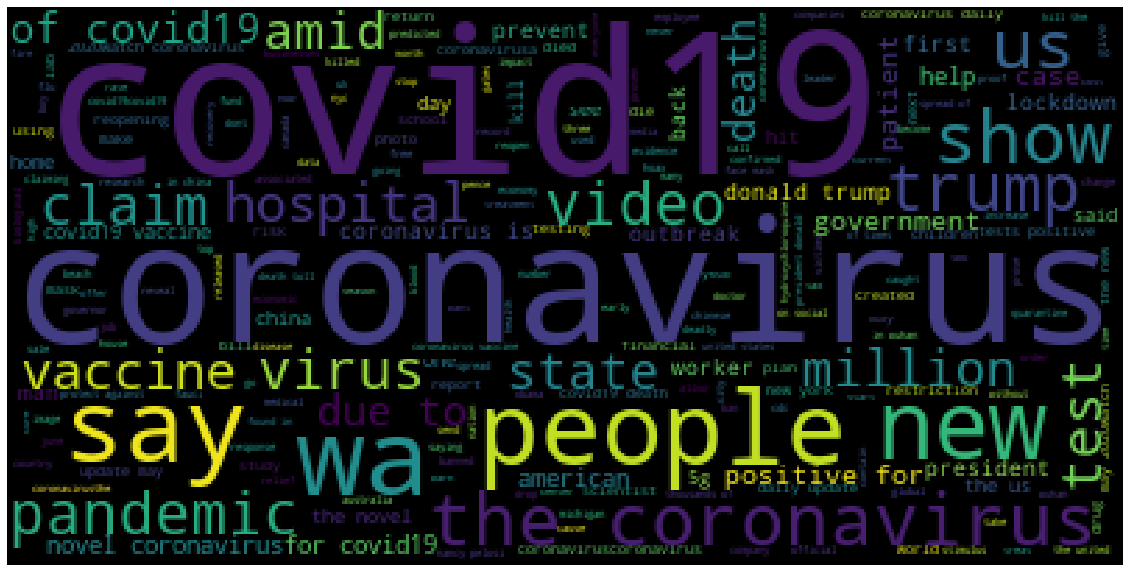

In [5]:
rcParams['figure.figsize'] = 20, 30
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Logistic Regression

In [6]:
#Pipeline for Cvec and logistic regresion
pipe_c_lr = Pipeline([('cvec', CountVectorizer()),
                  ('lr', LogisticRegression(solver = 'liblinear'))
                  ])

pipe_para_cvec = {
    'cvec__max_features': [100, 500, 1000],
    'cvec__ngram_range': [(1,2), (1,3), (1,4)],
    'cvec__stop_words' : ['english', None],
    'cvec__min_df': [2, 5, 10],
    'cvec__max_df': [.75, .80, .85, .95]
    }

In [7]:
#Pipeline for Tfidf and logistic regression
pipe_t_lr = Pipeline([('tvec', TfidfVectorizer()),
                  ('lr', LogisticRegression(solver = 'liblinear'))
                  ])

pipe_para_tfidf = {
        'tvec__max_features': [100, 500, 1000],
        'tvec__ngram_range': [(1,2), (1,3), (1,4)],
        'tvec__stop_words': ['english', None],
        'tvec__min_df'    : [2, 5, 10],
        'tvec__max_df'    : [.75, .80, .85, .96]
        
}

In [8]:
pipes = [pipe_c_lr, pipe_t_lr]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

#Let's set up our data for modeling. 
X = df['Text']
y = df['Label']

# Now let's make our training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    stratify=y,
                                                    random_state=42)

for i in range(0, len(pipe_names)):  

    gs = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs.fit(X_train, y_train)
    gs_estimator = gs.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs.best_score_}")
    print(f"Best Parameters = {gs.best_params_}")

Model:Countvectorizer
Best Train Score = 0.9508196721311475
Best Test Score = 0.8513853904282116
Best Overall Score = 0.8316519546027743
Best Parameters = {'cvec__max_df': 0.75, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9230769230769231
Best Test Score = 0.8564231738035264
Best Overall Score = 0.8366960907944514
Best Parameters = {'tvec__max_df': 0.75, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [9]:
#Let's take a look at our best estimator
print(gs_estimator)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=1000,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [10]:
#Let's generate our best Logistic Regression Predictions
lr_best_preds = gs_estimator.predict(X_test)

#Now let's generate our confusion matrix
lr_cm = confusion_matrix(y_test, lr_best_preds)
lr_cm_df = pd.DataFrame(lr_cm, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])
lr_cm_df

,Predicted Real,Predicted Fake
Actually Real,179,21
Actually Fake,36,161


In [11]:
# Now let's get our confusion matrix metrics 
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, lr_best_preds).ravel()

# What is the specificity of our test set?
spec_lr = tn_lr / (tn_lr + fp_lr)
print(f'Specificity: {round(spec_lr,4)}')

# What is the sensitivity of our test set?
sens_lr = tp_lr / (tp_lr + fn_lr)
print(f'Sensitivty: {round(sens_lr,4)}')

Specificity: 0.895
Sensitivty: 0.8173


# Decision Tree

In [12]:
#We could create one big pipeline specifying all of the different models we will create. 
#However I think it is best to look at the different methods and break them down along SHAP values to see if 
#There are any insights to take in
pipe_c_dt = Pipeline([('cvec', CountVectorizer()),
                  ('dt', DecisionTreeClassifier())
                  ])

pipe_t_dt = Pipeline([('tvec', TfidfVectorizer()),
                  ('dt', DecisionTreeClassifier())
                  ])

In [13]:
pipes = [pipe_c_dt, pipe_t_dt]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_dt = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_dt.fit(X_train, y_train)
    gs_estimator_dt = gs_dt.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_dt.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_dt.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_dt.best_score_}")
    print(f"Best Parameters = {gs_dt.best_params_}")

Model:Countvectorizer
Best Train Score = 0.9955863808322825
Best Test Score = 0.7909319899244333
Best Overall Score = 0.7591424968474149
Best Parameters = {'cvec__max_df': 0.95, 'cvec__max_features': 500, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9955863808322825
Best Test Score = 0.7934508816120907
Best Overall Score = 0.7610340479192939
Best Parameters = {'tvec__max_df': 0.85, 'tvec__max_features': 500, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': None}


In [14]:
#Let's take a look at our best estimator from our Decision Tree Models
print(gs_estimator_dt)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85, max_features=500,
                                 min_df=5, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('dt',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
        

In [15]:
#Let's look at predictions from our best decision tree classifier
dt_best_preds = gs_estimator_dt.predict(X_test)

#Now let's generate our confusion matrix
dt_cm = confusion_matrix(y_test, dt_best_preds)
dt_cm_df = pd.DataFrame(dt_cm, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])
dt_cm_df

,Predicted Real,Predicted Fake
Actually Real,163,37
Actually Fake,45,152


In [16]:
# Now let's get our confusion matrix metrics 
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, dt_best_preds).ravel()

# What is the specificity of our test set?
spec_dt = tn_dt / (tn_dt + fp_dt)
print(f'Specificity: {round(spec_dt,4)}')

# What is the sensitivity of our test set?
sens_dt = tp_dt / (tp_dt + fn_dt)
print(f'Sensitivty: {round(sens_dt,4)}')

Specificity: 0.815
Sensitivty: 0.7716


# Random Forest 

In [17]:
pipe_c_rf = Pipeline([('cvec', CountVectorizer()),
                  ('rf', RandomForestClassifier())
                  ])

pipe_t_rf = Pipeline([('tvec', TfidfVectorizer()),
                  ('rf', RandomForestClassifier())
                  ])

In [18]:
pipes = [pipe_c_rf, pipe_t_rf]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_rf = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_rf.fit(X_train, y_train)
    gs_estimator_rf = gs_rf.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_rf.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_rf.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_rf.best_score_}")
    print(f"Best Parameters = {gs_rf.best_params_}")

Model:Countvectorizer
Best Train Score = 0.9854981084489282
Best Test Score = 0.8110831234256927
Best Overall Score = 0.8121059268600253
Best Parameters = {'cvec__max_df': 0.75, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9924337957124842
Best Test Score = 0.836272040302267
Best Overall Score = 0.8064312736443884
Best Parameters = {'tvec__max_df': 0.8, 'tvec__max_features': 1000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': None}


In [23]:
print(gs_estimator_rf)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=1000,
                                 min_df=5, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [21]:
#Let's generate predictions
cvec_preds_rf = gs_estimator_rf.predict(X_test)

#And make our confusion matrix
cvec_cm_rf = confusion_matrix(y_test, cvec_preds_rf)
cvec_cm_rf_df = pd.DataFrame(cvec_cm_rf, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])

cvec_cm_rf_df

,Predicted Real,Predicted Fake
Actually Real,182,18
Actually Fake,47,150


In [22]:
#Now let's get our metrics 
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, cvec_preds_rf).ravel()

# What is the specificity of our test set?
spec_rf = tn_rf / (tn_rf + fp_rf)
print(f'Specificity: {round(spec_rf,4)}')

# What is the sensitivity of our test set?
sens_rf = tp_rf / (tp_rf + fn_rf)
print(f'Sensitivty: {round(sens_rf,4)}')

Specificity: 0.91
Sensitivty: 0.7614


# XGBOOST

In [24]:
pipe_c_xgb = Pipeline([('cvec', CountVectorizer()),
                  ('xgb', XGBClassifier())
                  ])

pipe_t_xgb = Pipeline([('tvec', TfidfVectorizer()),
                  ('xgb', XGBClassifier())
                  ])

In [25]:
pipes = [pipe_c_xgb, pipe_t_xgb]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_xgb = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_xgb.fit(X_train, y_train)
    gs_estimator_xgb = gs_xgb.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_xgb.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_xgb.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_xgb.best_score_}")
    print(f"Best Parameters = {gs_xgb.best_params_}")

Model:Countvectorizer
Best Train Score = 0.8329129886506935
Best Test Score = 0.8035264483627204
Best Overall Score = 0.7931904161412359
Best Parameters = {'cvec__max_df': 0.75, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.8619167717528373
Best Test Score = 0.8136020151133502
Best Overall Score = 0.7868852459016393
Best Parameters = {'tvec__max_df': 0.75, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': None}


In [26]:
print(gs_estimator_xgb)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=1000,
                                 min_df=2, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

In [27]:
#Let's generate predictions
cvec_preds_xgb = gs_estimator_xgb.predict(X_test)

#And make our confusion matrix
cvec_cm_xgb = confusion_matrix(y_test, cvec_preds_xgb)
cvec_cm_xgb_df = pd.DataFrame(cvec_cm_xgb, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])

cvec_cm_xgb_df

,Predicted Real,Predicted Fake
Actually Real,179,21
Actually Fake,53,144


In [28]:
#Now let's get our metrics 
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, cvec_preds_xgb).ravel()

# What is the specificity of our test set?
spec_xgb = tn_xgb / (tn_xgb + fp_xgb)
print(f'Specificity: {round(spec_xgb,4)}')

# What is the sensitivity of our test set?
sens_xgb = tp_xgb / (tp_xgb + fn_xgb)
print(f'Sensitivty: {round(sens_xgb,4)}')

Specificity: 0.895
Sensitivty: 0.731
